<a href="https://colab.research.google.com/github/catastropiyush/chocos/blob/main/mace_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A Short MACE Tutorial

## Introduction

This is a short tutorial for MACE, a highly accurate and efficient ML interatomic potential.
Please read the associated [paper](https://arxiv.org/pdf/2206.07697.pdf).
The reference implementation is available [here](https://github.com/ACEsuit/mace).

## Installation

In [1]:
# Install dependencies
!pip install e3nn==0.4.4 opt_einsum ase torch_ema prettytable

# Clone MACE
!git clone --depth 1 https://github.com/ACEsuit/mace.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 387.7/387.7 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 24.0 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinu

In [2]:
!pip install mace/

Processing ./mace
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.9/438.9 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 18.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 27.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.2 MB/s eta 0:00:00
  Created wheel for mace-torch: filename=mace_torch-0.3.5-py3-none-any.whl size=115005 sha256=a811dfc55018a7195c309b824f30322e3ea68e8e61fc49c0a2c102784e593f77
  Stored in directory: /tmp/pip-ephem-wheel-cache-k5acyhzo/wheels/df/5f/32/ef59561725170a81c728fd01c75e56a9ee83bad6da485fc6a5
  Created wheel for python-hostlist: filename=python_hostlist-1.23.0-py3-none-any.whl size=39722 sha256=e911c8983b44dd65ba257a6eceeafe1cf96297eff271dec23d486fa4c17db6a8
  Stored in directory: /

**Note:** Make sure to enable GPU: Runtime --> Change runtime type to GPU

## Loading Data
The data files used to train the MACE model have to be in `extxyz` format.
In this tutorial, we use the 3BPA dataset consisting of 500 configurations sampled a 300K with DFT.
The energies are in eV and forces in eV/A.

In [3]:
!git clone https://github.com/davkovacs/BOTNet-datasets.git

Cloning into 'BOTNet-datasets'...
remote: Enumerating objects: 57, done.
remote: Counting objects: 100% (57/57), done.
remote: Compressing objects: 100% (50/50), done.
remote: Total 57 (delta 13), reused 37 (delta 7), pack-reused 0
Receiving objects: 100% (57/57), 28.73 MiB | 17.92 MiB/s, done.
Resolving deltas: 100% (13/13), done.


In [4]:
!ls BOTNet-datasets/dataset_3BPA

iso_atoms.xyz  test_1200K.xyz  test_600K.xyz  train_300K.xyz
README.md      test_300K.xyz   test_dih.xyz   train_mixedT.xyz


## Training

To train a MACE model you can specify the training file with the `--train_file` flag. The validation set can either be specified as a separate file using the `--valid_file` keyword, or it can be specified as a fraction of the training set using the `--valid_fraction` keyword. It is also possible to provide a test set that only gets evaluated at the end of the training using the `--test_file` keyword. If you want to compute the RMSE for different parts of the training set separately, specify the `config_type` keyword in the `info` dict of the configurations.

When parsing the data files the energies are read using the keyword `energy` and the forces using the keyword `forces`. To change that, specify the `--energy_key` and `--forces_key`.

For illustration, we create a very small model with 16 invariant messages specified by `hidden_irreps='16x0e'`.

In [5]:
!python3 ./mace/scripts/run_train.py \
  --name="MACE_model" \
  --train_file="BOTNet-datasets/dataset_3BPA/train_300K.xyz" \
  --valid_fraction=0.05 \
  --test_file="BOTNet-datasets/dataset_3BPA/test_300K.xyz" \
  --E0s='{1:-13.663181292231226, 6:-1029.2809654211628, 7:-1484.1187695035828, 8:-2042.0330099956639}' \
  --model="ScaleShiftMACE" \
  --hidden_irreps='32x0e' \
  --r_max=4.0 \
  --batch_size=20 \
  --max_num_epochs=100 \
  --ema \
  --ema_decay=0.99 \
  --amsgrad \
  --default_dtype="float32" \
  --device=cpu \
  --seed=123 \
  --swa

2024-06-26 09:05:13.368 INFO: MACE version: 0.3.5
2024-06-26 09:05:13.368 INFO: Configuration: Namespace(config=None, name='MACE_model', seed=123, log_dir='logs', model_dir='.', checkpoints_dir='checkpoints', results_dir='results', downloads_dir='downloads', device='cpu', default_dtype='float32', distributed=False, log_level='INFO', error_table='PerAtomRMSE', model='ScaleShiftMACE', r_max=4.0, radial_type='bessel', num_radial_basis=8, num_cutoff_basis=5, pair_repulsion=False, distance_transform='None', interaction='RealAgnosticResidualInteractionBlock', interaction_first='RealAgnosticResidualInteractionBlock', max_ell=3, correlation=3, num_interactions=2, MLP_irreps='16x0e', radial_MLP='[64, 64, 64]', hidden_irreps='32x0e', num_channels=None, max_L=None, gate='silu', scaling='rms_forces_scaling', avg_num_neighbors=1, compute_avg_num_neighbors=True, compute_stress=False, compute_forces=True, train_file='BOTNet-datasets/dataset_3BPA/train_300K.xyz', valid_file=None, valid_fraction=0.05, 

It is possible to use `--model=MACE`, in order to have the correct limit for isolated atoms. This is recommanded for task studying bond breaking events.

## Run

The trained model is realidy usable to run some ASE MD for illustration. The Colab hardware are not very performant so we put a small number of timesteps for illustration.

In [22]:
from ase import units
from ase.md.langevin import Langevin
from ase.io import read, write
import numpy as np
import time

from mace.calculators import MACECalculator

calculator = MACECalculator(model_paths='/content/checkpoints/MACE_model_run-123.model', device='cpu')
init_conf = read('BOTNet-datasets/dataset_3BPA/test_1200K.xyz', '0')
init_conf.set_calculator(calculator)

dyn = Langevin(init_conf, 0.5*units.fs, temperature_K=510, friction=5e-3)
def write_frame():
        dyn.atoms.write('md_3bpa.xyz', append=True)
dyn.attach(write_frame, interval=5)
dyn.run(1000)
print("MD finished!")

No dtype selected, switching to float32 to match model dtype.


<ipython-input-22-f3d5eb5e9784>:11: DeprecationWarning: Please use atoms.calc = calc
  init_conf.set_calculator(calculator)


MD finished!


In [25]:
from mace.calculators import mace_mp
from ase import build
from ase.md import Langevin
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution
from ase import units

#macemp = mace_mp() # return the default medium ASE calculator equivalent to mace_mp(model="medium")
macemp = MACECalculator(model_paths='/content/checkpoints/MACE_model_run-123.model', device='cpu')

#macemp = mace_mp(model="large") # return a larger model
#macemp = mace_mp(model="https://tinyurl.com/y7uhwpje") # downlaod the model at the given url
#macemp = mace_mp(dispersion=True) # return a model with D3 dispersion correction
atoms = build.molecule('H2O')
atoms.calc = macemp

# Initialize velocities.
T_init = 300  # Initial temperature in K
MaxwellBoltzmannDistribution(atoms, T_init * units.kB)
# Set up the Langevin dynamics engine for NVT ensemble.
dyn = Langevin(atoms, 0.5 * units.fs, T_init * units.kB, 0.001)
def write_frame():
        dyn.atoms.write('new.xyz', append=True)
dyn.attach(write_frame, interval=5)
dyn.run(1000)
print("MD finished!")

No dtype selected, switching to float32 to match model dtype.


/usr/local/lib/python3.10/dist-packages/ase/md/md.py:53: FutureWarning: Specify the temperature in K using the 'temperature_K' argument
  warnings.warn(FutureWarning(w))


MD finished!


In [29]:
from ase import Atoms
d = 1.10
molecule = Atoms('2N', positions=[(0., 0., 0.), (0., 0., d)])

In [39]:
from ase import Atoms
from ase.build import add_adsorbate, fcc111
from ase.calculators.emt import EMT
from ase.constraints import FixAtoms
from ase.optimize import QuasiNewton

h = 1.85
d = 1.10

slab = fcc111('Cu', size=(4, 4, 2), vacuum=10.0)

slab.calc = mace_mp()
e_slab = slab.get_potential_energy()

molecule = Atoms('2N', positions=[(0., 0., 0.), (0., 0., d)])
molecule.calc = mace_mp()
e_N2 = molecule.get_potential_energy()

add_adsorbate(slab, molecule, h, 'ontop')
constraint = FixAtoms(mask=[a.symbol != 'N' for a in slab])
slab.set_constraint(constraint)
dyn = QuasiNewton(slab, trajectory='N2Cu.traj')
dyn.run(fmax=0.05)

print('Adsorption energy:', e_slab + e_N2 - slab.get_potential_energy())


Using Materials Project MACE for MACECalculator with /root/.cache/mace/5yyxdm76
Using float32 for MACECalculator, which is faster but less accurate. Recommended for MD. Use float64 for geometry optimization.
Default dtype float32 does not match model dtype float64, converting models to float32.
Using Materials Project MACE for MACECalculator with /root/.cache/mace/5yyxdm76
Using float32 for MACECalculator, which is faster but less accurate. Recommended for MD. Use float64 for geometry optimization.
Default dtype float32 does not match model dtype float64, converting models to float32.
                Step[ FC]     Time          Energy          fmax
BFGSLineSearch:    0[  0] 10:48:00     -132.257050       2.7887
BFGSLineSearch:    1[  2] 10:48:01     -132.278915       0.7934
BFGSLineSearch:    2[  3] 10:48:02     -132.281464       0.1166
BFGSLineSearch:    3[  4] 10:48:03     -132.281509       0.0092
Adsorption energy: 0.5836696624755859


In [40]:
import os
import ase.io
import numpy as np
from ase.build import add_adsorbate, fcc100, molecule
from ase.constraints import FixAtoms
from ase.optimize import LBFGS

# Construct a sample structure, similar to the EMT relaxation example!
adslab = fcc100("Cu", size=(3, 3, 3))
adsorbate = molecule("CH3O")
add_adsorbate(adslab, adsorbate, 3, offset=(1, 1))
tags = np.zeros(len(adslab))
tags[18:27] = 1
tags[27:] = 2
adslab.set_tags(tags)
cons = FixAtoms(indices=[atom.index for atom in adslab if (atom.tag == 0)])
adslab.set_constraint(cons)
adslab.center(vacuum=13.0, axis=2)
adslab.set_pbc(True)

# Define the calculator
calc = mace_mp()

# Set up the calculator
adslab.set_calculator(calc)

os.makedirs("data", exist_ok=True)
opt = LBFGS(adslab, trajectory="data/ml_Cu100+CH3O.traj")
opt.run(fmax=0.05, steps=100)

Using Materials Project MACE for MACECalculator with /root/.cache/mace/5yyxdm76
Using float32 for MACECalculator, which is faster but less accurate. Recommended for MD. Use float64 for geometry optimization.
Default dtype float32 does not match model dtype float64, converting models to float32.


<ipython-input-40-59dccec6c115>:25: DeprecationWarning: Please use atoms.calc = calc
  adslab.set_calculator(calc)


       Step     Time          Energy          fmax
LBFGS:    0 10:49:29     -124.634026        1.220878
LBFGS:    1 10:49:30     -124.659569        0.465146
LBFGS:    2 10:49:31     -124.673065        0.522797
LBFGS:    3 10:49:32     -124.686691        0.490398
LBFGS:    4 10:49:33     -124.700554        0.528972
LBFGS:    5 10:49:34     -124.719070        0.637922
LBFGS:    6 10:49:35     -124.749733        0.706212
LBFGS:    7 10:49:36     -124.802597        0.876245
LBFGS:    8 10:49:36     -124.852470        1.074315
LBFGS:    9 10:49:37     -124.914810        1.764278
LBFGS:   10 10:49:38     -125.025848        2.020515
LBFGS:   11 10:49:38     -125.110451        1.938302
LBFGS:   12 10:49:39     -125.292953        1.915168
LBFGS:   13 10:49:40     -125.398346        1.849662
LBFGS:   14 10:49:41     -125.643387        2.222223
LBFGS:   15 10:49:41     -125.814888        1.801915
LBFGS:   16 10:49:42     -125.877434        0.684943
LBFGS:   17 10:49:43     -125.924576        1.00

False

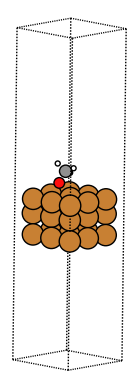

In [41]:
import matplotlib.pyplot as plt
from ase.visualize.plot import animate
from matplotlib import rc

# the `index` argument corresponds to what frame of the trajectory to read in, specifiying ":" reads in the full trajectory.
traj = ase.io.read("data/ml_Cu100+CH3O.traj", index=":")
anim = animate(traj, radii=0.8, rotation=("-75x, 45y, 10z"))

rc("animation", html="jshtml")
anim

In [33]:
from ase.visualize import view

view(slab)

<Popen: returncode: None args: ['/usr/bin/python3', '-m', 'ase', 'gui', '-']>

In [32]:
from ase.optimize import QuasiNewton
dyn = QuasiNewton(slab, trajectory='N2Cu.traj')
dyn.run(fmax=0.05)

                Step[ FC]     Time          Energy          fmax
BFGSLineSearch:    0[  0] 10:35:56     -132.281509       0.0092


True

In [35]:
# prompt: how to convert the N2Cu.traj to a xyz file

from ase.io import Trajectory
from ase.io import write

traj = Trajectory('N2Cu.traj')
write('N2Cu.xyz', traj[0])
for i in range(1, len(traj)):
  write('N2Cu.xyz', traj[i], append=True)


/usr/local/lib/python3.10/dist-packages/ase/io/extxyz.py:311: UserWarning: Skipping unhashable information adsorbate_info
  warnings.warn('Skipping unhashable information '


In [28]:
from mace.calculators import mace_mp
from ase import build
from ase.md import Langevin
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution
from ase import units

macemp = mace_mp() # return the default medium ASE calculator equivalent to mace_mp(model="medium")
#macemp = mace_mp(model="large") # return a larger model
#macemp = mace_mp(model="https://tinyurl.com/y7uhwpje") # downlaod the model at the given url
#macemp = mace_mp(dispersion=True) # return a model with D3 dispersion correction
atoms = build.molecule('H2O')
atoms.calc = macemp

# Initialize velocities.
T_init = 300  # Initial temperature in K
MaxwellBoltzmannDistribution(atoms, T_init * units.kB)

# Set up the Langevin dynamics engine for NVT ensemble.
dyn = Langevin(atoms, 0.5 * units.fs, T_init * units.kB, 0.001)
def write_frame():
        dyn.atoms.write('new1.xyz', append=True)
dyn.attach(write_frame, interval=5)
dyn.run(1000)
print("MD finished!")

Using Materials Project MACE for MACECalculator with /root/.cache/mace/5yyxdm76
Using float32 for MACECalculator, which is faster but less accurate. Recommended for MD. Use float64 for geometry optimization.
Default dtype float32 does not match model dtype float64, converting models to float32.


/usr/local/lib/python3.10/dist-packages/ase/md/md.py:53: FutureWarning: Specify the temperature in K using the 'temperature_K' argument
  warnings.warn(FutureWarning(w))


MD finished!


In [12]:
# prompt: visualize the final molecule xyz
!pip install nglview
from nglview import show_mdtraj
# Load the trajectory
traj = md.load('md_3bpa.xyz')
# Visualize the final molecule
show_mdtraj(traj[-1])

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 19.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.4/139.4 kB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 66.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 75.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.4/383.4 kB 39.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 49.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 54.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.9/105.9 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.1/117.1 k

NameError: name 'md' is not defined

In [16]:
!pip install rdkit-pypi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 29.6 MB/s eta 0:00:00


In [19]:
# prompt: visualize the xyz file using Rdkit

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import IPythonConsole
from IPython.display import SVG

xyz_file = 'md_3bpa.xyz'

# Read the molecule from the XYZ file
molecule = Chem.MolFromXYZFile(xyz_file)

# Generate 2D depiction of the molecule
AllChem.Compute2DCoords(molecule)

# Display the molecule using SVG
SVG(AllChem.MolToChemDrawOrV3K(molecule))


[10:09:59] Cannot convert '-1.84807340       0.00000000       0.00000000       0.00000000       1.34129024      -0.65188783       0.13783827' to double on line 2



ArgumentError: Python argument types in
    rdkit.Chem.rdDepictor.Compute2DCoords(NoneType)
did not match C++ signature:
    Compute2DCoords(RDKit::ROMol {lvalue} mol, bool canonOrient=True, bool clearConfs=True, boost::python::dict {lvalue} coordMap={}, unsigned int nFlipsPerSample=0, unsigned int nSample=0, int sampleSeed=0, bool permuteDeg4Nodes=False, double bondLength=-1.0, bool forceRDKit=False)